In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    import torch  # type: ignore[import]
    import torch.nn as nn  # type: ignore[import]
    from torch.utils.data import TensorDataset, DataLoader, random_split  # type: ignore[import]
except ImportError as exc:
    raise ImportError(
        "PyTorch is required for this notebook. Please install torch."
    ) from exc
try:
    from sklearn.preprocessing import MinMaxScaler  # type: ignore[import]
except ImportError as exc:
    raise ImportError(
        "scikit-learn is required for this notebook. Please install scikit-learn."
    ) from exc

torch.manual_seed(42)

import sys
root_dir = os.path.abspath("..")
if root_dir not in sys.path:
    sys.path.append(root_dir)
# print("Project root in sys.path:", root_dir)

from src.config import (
    CMAPSS_DATASETS,
    MAX_RUL,
    SEQUENCE_LENGTH,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    LEARNING_RATE,
    NUM_EPOCHS,
    GLOBAL_FEATURE_COLS,
    GLOBAL_DROP_COLS 
)

from src.data_loading import load_cmapps_subset, get_feature_drop_cols
from src.training import build_eol_sequences_from_df, SEQUENCE_LENGTH, MAX_RUL
from src.world_model_training import train_eol_regressor_from_world_model
from src.models.world_model import WorldModelEncoderDecoderMultiTask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import importlib
import src.world_model_training as wmt

importlib.reload(wmt)

from src.data_loading import load_cmapps_global
from src.additional_features import create_physical_features
from src.config import GLOBAL_FEATURE_COLS, GLOBAL_DROP_COLS
from src.world_model_training import train_world_model_global_multitask, train_eol_regressor_from_world_model

# 1) globale Trainingsdaten bauen (Pseudo-Code, an deine Signaturen anpassen)
dfs = []
for fd_id in ["FD001"]: #, "FD002", "FD003", "FD004"
    df_train, _, _ = load_cmapps_subset(fd_id)  # ggf. add_rul=True etc.
    df_train = create_physical_features(df_train)
    df_train["FD_ID"] = fd_id
    dfs.append(df_train)

df_train_global = pd.concat(dfs, ignore_index=True)

# 2) Featureliste definieren (wie beim globalen LSTM)
numeric_cols = df_train_global[GLOBAL_FEATURE_COLS].select_dtypes(
    include=["number"]
).columns.tolist()
feature_cols = numeric_cols

past_len = SEQUENCE_LENGTH 

# Use the updated function that handles train/val split internally
# 3) Pretrained World Model laden
world_model = WorldModelEncoderDecoderMultiTask(
    input_size=len(feature_cols),
    hidden_size=64,   # dein Wert
    num_layers=2,
    output_size=1,
    dropout=0.1,
)

# Load state dict, ignoring EOL head mismatch (we'll train a separate EOL regressor)
checkpoint = torch.load("../results/world_model_multitask/world_model_multitask_best.pt", map_location=device)
# Filter out EOL head keys since we're training a separate regressor
filtered_state_dict = {k: v for k, v in checkpoint.items() if not k.startswith("eol_head")}
world_model.load_state_dict(filtered_state_dict, strict=False)
print(f"Loaded model weights (excluding EOL head). Loaded {len(filtered_state_dict)}/{len(checkpoint)} parameters.")

# 4) EOL-Regressor trainieren (function now handles dataset creation and train/val split)
eol_regressor, history = train_eol_regressor_from_world_model(
    world_model=world_model,
    df_train=df_train_global,
    feature_cols=feature_cols,
    past_len=past_len,
    hidden_size=64,    # = world_model.hidden_size
    device=device,
    max_rul=MAX_RUL,
    val_split=0.2,
    batch_size=32,
    num_epochs=50,
    lr=1e-3,
    random_seed=42,
)

torch.save(eol_regressor.state_dict(), "../results/eol_regressor_fd001.pt")

New columns successfully added. Current number of columns: 32
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio  RUL
0             0.941013        0.2       0.403737  125
1             0.943169        0.2       0.403406  125
2             0.942554       -1.8       0.404505  125
3             0.943025        0.2       0.405834  125
4             0.942581        1.2       0.405831  125
Loaded model weights (excluding EOL head). Loaded 18/20 parameters.
[EOLReg] Built EOL sequences: X=torch.Size([100, 30, 24]), y=torch.Size([100])
[EOLReg] RUL stats: min=0.00, max=125.00, mean=83.17
[EOLReg] Dataset sizes: train=80, val=20
[EOLReg] Epoch 1/50 - train_loss: 8385.2156, val_loss: 7933.5283, val_RMSE: 89.0704
[EOLReg] Epoch 2/50 - train_loss: 8292.8023, val_loss: 7831.4580, val_RMSE: 88.4955
[EOLReg] Epoch 3/50 - train_loss: 8184.9233, val_loss: 7710.8750, val_RMSE: 87.8116
[EOLReg] Epoch 4/50 - train_loss: 8056.0076, val_loss: 7554.8779, val_RMSE: 86.9188
[EOLReg] Epoch 5/50 - train_loss: 789

In [4]:
# --- GLOBAL TEST ---
dfs_test = []

for fd_id in ["FD001"]:  #"FD002", "FD003", "FD004"
    df_train, df_test, rul_test = load_cmapps_subset(fd_id)

    # 1) MaxTime pro Unit im TEST berechnen
    max_cycles = (
        df_test.groupby("UnitNumber")["TimeInCycles"]
        .max()
        .rename("MaxTime")
        .reset_index()
    )
    df_test = df_test.merge(max_cycles, on="UnitNumber", how="left")

    # 2) RUL_last pro Unit aus rul_test bauen
    #    Wir gehen davon aus: rul_test ist in der Reihenfolge Unit 1..N
    units = (
        df_test[["UnitNumber"]]
        .drop_duplicates()
        .sort_values("UnitNumber")
        .reset_index(drop=True)
    )
    rul_df = pd.DataFrame({
        "UnitNumber": units["UnitNumber"].values,
        "RUL_last": rul_test.reshape(-1),
    })

    df_test = df_test.merge(rul_df, on="UnitNumber", how="left")

    # 3) RUL(t) = RUL_last + (MaxTime - TimeInCycles)
    df_test["RUL"] = df_test["RUL_last"] + (df_test["MaxTime"] - df_test["TimeInCycles"])

    # 4) Optional: RUL clamping wie im Training
    df_test["RUL"] = df_test["RUL"].clip(upper=MAX_RUL)

    # 5) Physikfeatures ergänzen
    df_test = create_physical_features(df_test)

    # 6) FD_ID hinzufügen
    df_test["FD_ID"] = fd_id

    dfs_test.append(df_test)

df_test_global = pd.concat(dfs_test, ignore_index=True)

print("df_test_global columns:", df_test_global.columns)
print(df_test_global[["FD_ID", "UnitNumber", "TimeInCycles", "MaxTime", "RUL"]].head())

import importlib
import src.world_model_training as wmt

importlib.reload(wmt)

from src.world_model_training import evaluate_world_model_eol

eol_metrics = evaluate_world_model_eol(
    model=world_model,
    df_global_test=df_test_global,
    feature_cols=feature_cols,
    past_len=30,   # konsistent mit deinem LSTM
)

print("EOL metrics (World Model, literature-style):")
for k, v in eol_metrics.items():
    print(f"{k}: {v}")


New columns successfully added. Current number of columns: 33
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio    RUL
0             0.941903        0.3       0.405617  125.0
1             0.941083        1.3       0.403985  125.0
2             0.941997        1.3       0.404842  125.0
3             0.941000       -0.7       0.405550  125.0
4             0.942237       -1.7       0.404810  125.0
df_test_global columns: Index(['UnitNumber', 'TimeInCycles', 'Setting1', 'Setting2', 'Setting3',
       'Sensor1', 'Sensor2', 'Sensor3', 'Sensor4', 'Sensor5', 'Sensor6',
       'Sensor7', 'Sensor8', 'Sensor9', 'Sensor10', 'Sensor11', 'Sensor12',
       'Sensor13', 'Sensor14', 'Sensor15', 'Sensor16', 'Sensor17', 'Sensor18',
       'Sensor19', 'Sensor20', 'Sensor21', 'ConditionID', 'MaxTime',
       'RUL_last', 'RUL', 'Effizienz_HPC_Proxy', 'EGT_Drift', 'Fan_HPC_Ratio',
       'FD_ID'],
      dtype='object')
   FD_ID  UnitNumber  TimeInCycles  MaxTime    RUL
0  FD001           1             1     

In [5]:
# ============================================================================
# Test-Set EOL-Metriken mit trainiertem EOL-Regressor
# ============================================================================

from src.training import build_eol_sequences_from_df
from src.models.eol_regressor import EOLRegressor
from src.eval_utils import compute_nasa_score_pairwise

# a) Test-EOL-Samples bauen mit mode="test"
print("=" * 60)
print("Building Test EOL Sequences...")
print("=" * 60)

X_test_eol, y_test_eol = build_eol_sequences_from_df(
    df=df_test_global,
    feature_cols=feature_cols,
    past_len=past_len,
    max_rul=MAX_RUL,
    unit_col="UnitNumber",
    cycle_col="TimeInCycles",
    rul_col="RUL",
    mode="test",
)

print(f"Test EOL X: {X_test_eol.shape}, y: {y_test_eol.shape}")
print(f"Test RUL stats: min={float(y_test_eol.min()):.2f}, "
      f"max={float(y_test_eol.max()):.2f}, mean={float(y_test_eol.mean()):.2f}")

# b) Test-Loader + Vorhersage
print("\n" + "=" * 60)
print("Making Predictions with WorldModel + EOLRegressor...")
print("=" * 60)

class EOLDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X.float()
        self.y = y.float().view(-1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

test_ds = EOLDataset(X_test_eol, y_test_eol)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

world_model.eval()
eol_regressor.eval()

all_pred = []
all_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).float()

        # Encoder summary extrahieren
        enc_out, (h_n, c_n) = world_model.encoder(X_batch)
        enc_summary = h_n[-1]  # [B, hidden_size]

        # EOL-Regressor Vorhersage
        pred = eol_regressor(enc_summary).squeeze(-1)

        all_pred.append(pred.cpu())
        all_true.append(y_batch.cpu())

pred_rul = torch.cat(all_pred).numpy()
true_rul = torch.cat(all_true).numpy()

print(f"pred_rul (first 10): {pred_rul[:10]}")
print(f"true_rul (first 10): {true_rul[:10]}")

# c) EOL-Metriken berechnen
print("\n" + "=" * 60)
print("EOL Metrics (Test Set) - WorldModel + EOLRegressor")
print("=" * 60)

# Basis-Metriken
errors = pred_rul - true_rul
mse = np.mean(errors ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(errors))
bias = np.mean(errors)

print(f"MSE:  {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")
print(f"Bias: {bias:.3f}")

# NASA-Score
nasa_metrics = compute_nasa_score_pairwise(true_rul, pred_rul)
print(f"\nNASA Score (sum):   {nasa_metrics['nasa_score_sum']:.3f}")
print(f"NASA Score (mean):  {nasa_metrics['nasa_score_mean']:.3f}")
print(f"Number of engines:  {nasa_metrics['num_samples']}")

# Results DataFrame für weitere Analysen
# UnitNumber in derselben Reihenfolge wie build_eol_sequences_from_df extrahieren
unit_ids = []
for unit_id, df_unit in df_test_global.groupby("UnitNumber"):
    df_unit = df_unit.sort_values("TimeInCycles")
    if len(df_unit) >= past_len:
        unit_ids.append(unit_id)

results_df_eol_regressor = pd.DataFrame({
    "UnitNumber": unit_ids,
    "true_rul": true_rul,
    "pred_rul": pred_rul,
    "error": errors,
})

print("\n" + "=" * 60)
print("Summary: EOL-Regressor Test Metrics")
print("=" * 60)
print(f"RMSE: {rmse:.2f} cycles")
print(f"MAE:  {mae:.2f} cycles")
print(f"Bias: {bias:.2f} cycles")
print(f"NASA Score (mean): {nasa_metrics['nasa_score_mean']:.2f}")
print("\n" + "=" * 60)


Building Test EOL Sequences...
Test EOL X: torch.Size([100, 30, 24]), y: torch.Size([100])
Test RUL stats: min=7.00, max=125.00, mean=74.45

Making Predictions with WorldModel + EOLRegressor...
pred_rul (first 10): [82.54023 82.54023 82.54023 82.54023 82.54023 82.54023 82.54023 82.54023
 82.54023 82.54023]
true_rul (first 10): [112.  98.  69.  82.  91.  93.  91.  95. 111.  96.]

EOL Metrics (Test Set) - WorldModel + EOLRegressor
MSE:  1671.319
RMSE: 40.882
MAE:  34.918
Bias: 8.090

NASA Score (sum):   21998.498
NASA Score (mean):  219.985
Number of engines:  100

Summary: EOL-Regressor Test Metrics
RMSE: 40.88 cycles
MAE:  34.92 cycles
Bias: 8.09 cycles
NASA Score (mean): 219.98



Building Trajectory Test Sequences...
[WARN] Unit 1: insufficient data (31 < 50), skipping
[WARN] Unit 2: insufficient data (49 < 50), skipping
[WARN] Unit 14: insufficient data (46 < 50), skipping
[WARN] Unit 22: insufficient data (39 < 50), skipping
[WARN] Unit 25: insufficient data (48 < 50), skipping
[WARN] Unit 39: insufficient data (37 < 50), skipping
[WARN] Unit 85: insufficient data (34 < 50), skipping
[INFO] Test set: 93 engines, past_len=30, horizon=20, features=24

Running World Model on all test engines...

Computing Per-Engine Trajectory Metrics...
[INFO] Trajectory RMSE (mean over engines): 4.403
[INFO] Trajectory MAE  (mean over engines): 3.808
[INFO] Trajectory Bias (mean over engines): -2.781

[INFO] Representative engines:
  Best:  Unit 56 (index 49), RMSE=0.88
  Median: Unit 19 (index 15), RMSE=1.98
  Worst: Unit 96 (index 88), RMSE=12.18

Plotting Example Trajectories...


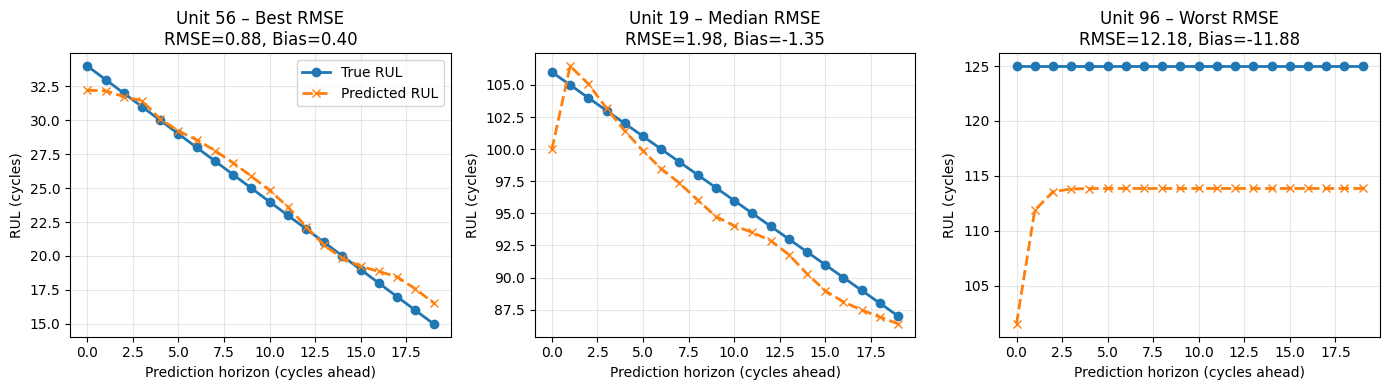


Plotting Error Heatmap...


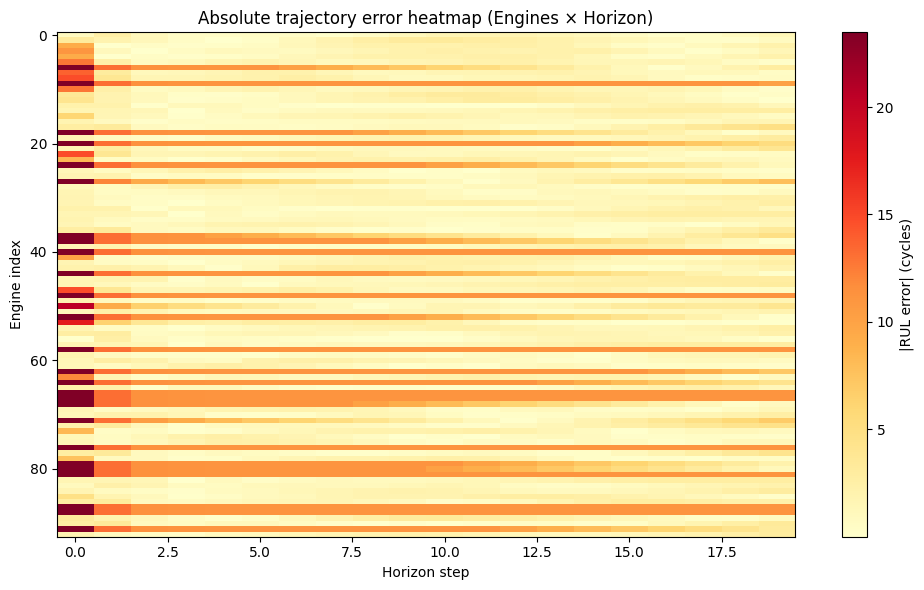


Plotting Trajectory RMSE Distribution...


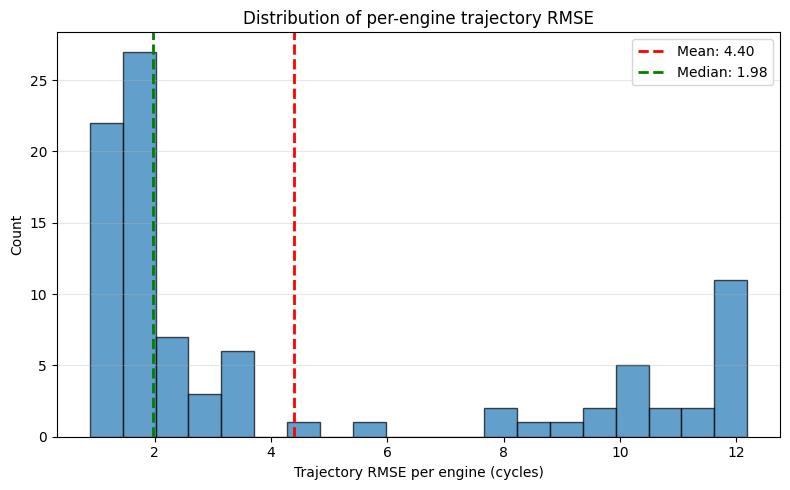


Plotting EOL Prediction Scatter...


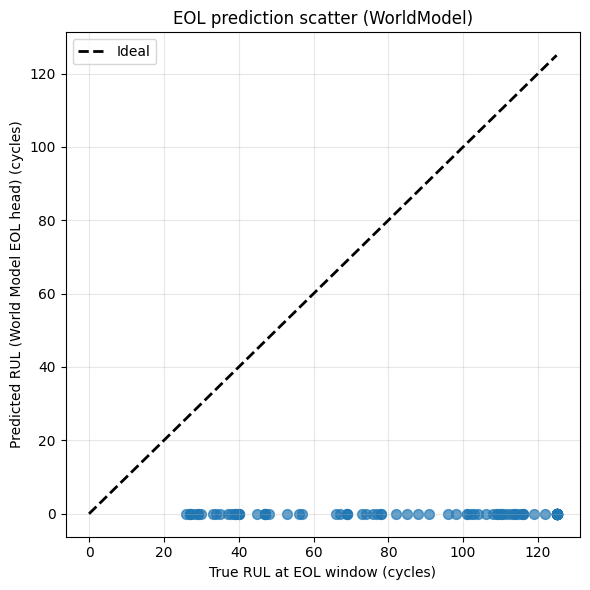


Plotting RMSE vs. True EOL-RUL...


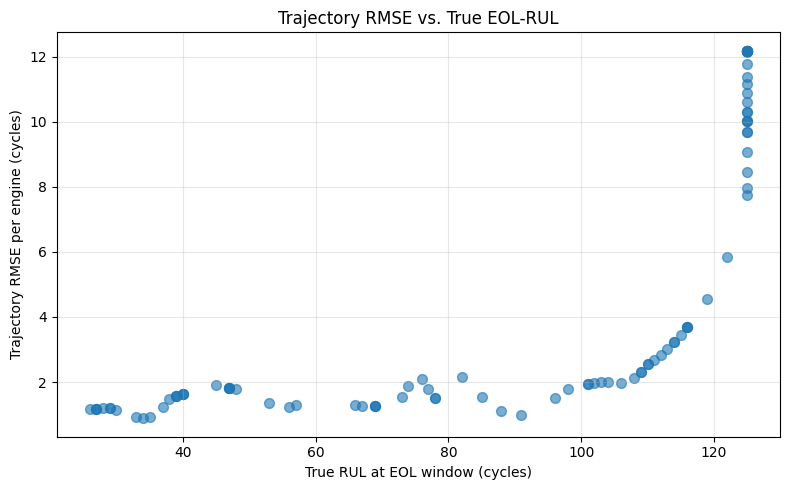


Summary Statistics
Number of engines analyzed: 93

Trajectory Metrics (over all engines):
  Mean RMSE: 4.403 ± 4.129 cycles
  Mean MAE:  3.808 ± 3.954 cycles
  Mean Bias: -2.781 ± 4.565 cycles

EOL Prediction (World Model head):
  RMSE: 94.292 cycles
  MAE:  87.134 cycles
  Bias: -87.134 cycles


In [7]:
# ============================================================================
# Trajectory Analysis: World Model auf allen Test-Engines
# ============================================================================

from src.world_model_training import build_seq2seq_samples_from_df

# Parameter
horizon = 20  # Standard-Horizon für World Model
print("=" * 60)
print("Building Trajectory Test Sequences...")
print("=" * 60)

# Pro Engine genau EIN Sample: das letzte mögliche Fenster
# Input: past_len Zyklen, Output: horizon Zyklen
X_test_list = []
Y_test_list = []
unit_ids_list = []

for unit_id, df_unit in df_test_global.groupby("UnitNumber"):
    df_unit = df_unit.sort_values("TimeInCycles")
    
    # Prüfe, ob genug Daten für past_len + horizon vorhanden sind
    if len(df_unit) < past_len + horizon:
        print(f"[WARN] Unit {unit_id}: insufficient data ({len(df_unit)} < {past_len + horizon}), skipping")
        continue
    
    # Erstelle Sequenzen für diese Engine
    X_np, Y_np = build_seq2seq_samples_from_df(
        df=df_unit,
        feature_cols=feature_cols,
        target_cols=["RUL"],
        past_len=past_len,
        horizon=horizon,
    )
    
    if X_np.shape[0] == 0:
        continue
    
    # Nimm nur das LETZTE Sample (das am weitesten in der Zukunft liegt)
    X_test_list.append(X_np[-1:])  # [1, past_len, num_features]
    Y_test_list.append(Y_np[-1:])  # [1, horizon, 1]
    unit_ids_list.append(unit_id)

# Stack zu [N_engines, past_len, num_features] und [N_engines, horizon, 1]
X_test = np.concatenate(X_test_list, axis=0)
Y_test = np.concatenate(Y_test_list, axis=0)

# Konvertiere zu PyTorch Tensors
X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).float()

N, past_len_actual, num_features = X_test.shape
horizon_actual = Y_test.shape[1]

print(f"[INFO] Test set: {N} engines, past_len={past_len_actual}, horizon={horizon_actual}, features={num_features}")

# ============================================================================
# 1) Run World Model auf allen Engines
# ============================================================================
print("\n" + "=" * 60)
print("Running World Model on all test engines...")
print("=" * 60)

world_model.eval()
X_test = X_test.to(device)
Y_test = Y_test.to(device)

with torch.no_grad():
    # Use teacher_forcing_ratio=0 during evaluation
    traj_pred, eol_pred = world_model(
        encoder_inputs=X_test,
        decoder_targets=Y_test,  # only used for initial token; ratio=0.0 -> no forcing
        teacher_forcing_ratio=0.0,
        horizon=horizon_actual,
    )

traj_pred_np = traj_pred.detach().cpu().numpy()[..., 0]  # shape [N, H]
true_traj_np = Y_test.detach().cpu().numpy()[..., 0]     # shape [N, H]
eol_pred_np  = eol_pred.detach().cpu().numpy().reshape(-1)  # shape [N]
eol_true_np  = true_traj_np[:, 0]  # by convention: first step = EOL+1 prediction target

# ============================================================================
# 2) Per-Engine Trajectory Metriken
# ============================================================================
print("\n" + "=" * 60)
print("Computing Per-Engine Trajectory Metrics...")
print("=" * 60)

traj_error = traj_pred_np - true_traj_np         # [N, H]
traj_abs_error = np.abs(traj_error)              # [N, H]

engine_rmse = np.sqrt(np.mean(traj_error**2, axis=1))   # [N]
engine_mae  = np.mean(traj_abs_error, axis=1)           # [N]
engine_bias = np.mean(traj_error, axis=1)               # [N]

print(f"[INFO] Trajectory RMSE (mean over engines): {engine_rmse.mean():.3f}")
print(f"[INFO] Trajectory MAE  (mean over engines): {engine_mae.mean():.3f}")
print(f"[INFO] Trajectory Bias (mean over engines): {engine_bias.mean():.3f}")

# ============================================================================
# 3) Representative Engines auswählen: best, median, worst
# ============================================================================
sorted_idx = np.argsort(engine_rmse)
idx_best   = sorted_idx[0]
idx_med    = sorted_idx[len(sorted_idx)//2]
idx_worst  = sorted_idx[-1]

repr_indices = [idx_best, idx_med, idx_worst]
repr_labels  = ["Best RMSE", "Median RMSE", "Worst RMSE"]
repr_units   = [unit_ids_list[i] for i in repr_indices]

print(f"\n[INFO] Representative engines:")
print(f"  Best:  Unit {repr_units[0]} (index {idx_best}), RMSE={engine_rmse[idx_best]:.2f}")
print(f"  Median: Unit {repr_units[1]} (index {idx_med}), RMSE={engine_rmse[idx_med]:.2f}")
print(f"  Worst: Unit {repr_units[2]} (index {idx_worst}), RMSE={engine_rmse[idx_worst]:.2f}")

# ============================================================================
# 4) Plot: Example Trajectories
# ============================================================================
print("\n" + "=" * 60)
print("Plotting Example Trajectories...")
print("=" * 60)

t = np.arange(horizon_actual)

plt.figure(figsize=(14, 4))
for k, (idx, label, unit_id) in enumerate(zip(repr_indices, repr_labels, repr_units), start=1):
    plt.subplot(1, 3, k)
    plt.plot(t, true_traj_np[idx],  marker="o", label="True RUL", linewidth=2, markersize=6)
    plt.plot(t, traj_pred_np[idx], marker="x", linestyle="--", label="Predicted RUL", linewidth=2, markersize=6)
    plt.title(f"Unit {unit_id} – {label}\nRMSE={engine_rmse[idx]:.2f}, Bias={engine_bias[idx]:.2f}")
    plt.xlabel("Prediction horizon (cycles ahead)")
    plt.ylabel("RUL (cycles)")
    plt.grid(True, alpha=0.3)
    if k == 1:
        plt.legend()

plt.tight_layout()
plt.show()

# ============================================================================
# 5) Plot: Error Heatmap
# ============================================================================
print("\n" + "=" * 60)
print("Plotting Error Heatmap...")
print("=" * 60)

plt.figure(figsize=(10, 6))
im = plt.imshow(traj_abs_error, aspect="auto", interpolation="nearest", cmap="YlOrRd")
plt.colorbar(im, label="|RUL error| (cycles)")
plt.xlabel("Horizon step")
plt.ylabel("Engine index")
plt.title("Absolute trajectory error heatmap (Engines × Horizon)")
plt.tight_layout()
plt.show()

# ============================================================================
# 6) Plot: Histogram of per-engine trajectory RMSE
# ============================================================================
print("\n" + "=" * 60)
print("Plotting Trajectory RMSE Distribution...")
print("=" * 60)

plt.figure(figsize=(8, 5))
plt.hist(engine_rmse, bins=20, edgecolor="black", alpha=0.7)
plt.axvline(engine_rmse.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {engine_rmse.mean():.2f}")
plt.axvline(np.median(engine_rmse), color="green", linestyle="--", linewidth=2, label=f"Median: {np.median(engine_rmse):.2f}")
plt.xlabel("Trajectory RMSE per engine (cycles)")
plt.ylabel("Count")
plt.title("Distribution of per-engine trajectory RMSE")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# 7) Plot: EOL Scatter (World Model EOL head)
# ============================================================================
print("\n" + "=" * 60)
print("Plotting EOL Prediction Scatter...")
print("=" * 60)

plt.figure(figsize=(6, 6))
plt.scatter(eol_true_np, eol_pred_np, alpha=0.7, s=50)
min_val = min(eol_true_np.min(), eol_pred_np.min())
max_val = max(eol_true_np.max(), eol_pred_np.max())
plt.plot([min_val, max_val], [min_val, max_val], "k--", label="Ideal", linewidth=2)
plt.xlabel("True RUL at EOL window (cycles)")
plt.ylabel("Predicted RUL (World Model EOL head) (cycles)")
plt.title("EOL prediction scatter (WorldModel)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# 8) Zusätzliche Analyse: RMSE vs. True EOL-RUL
# ============================================================================
print("\n" + "=" * 60)
print("Plotting RMSE vs. True EOL-RUL...")
print("=" * 60)

plt.figure(figsize=(8, 5))
plt.scatter(eol_true_np, engine_rmse, alpha=0.6, s=50)
plt.xlabel("True RUL at EOL window (cycles)")
plt.ylabel("Trajectory RMSE per engine (cycles)")
plt.title("Trajectory RMSE vs. True EOL-RUL")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# Summary Statistics
# ============================================================================
print("\n" + "=" * 60)
print("Summary Statistics")
print("=" * 60)
print(f"Number of engines analyzed: {N}")
print(f"\nTrajectory Metrics (over all engines):")
print(f"  Mean RMSE: {engine_rmse.mean():.3f} ± {engine_rmse.std():.3f} cycles")
print(f"  Mean MAE:  {engine_mae.mean():.3f} ± {engine_mae.std():.3f} cycles")
print(f"  Mean Bias: {engine_bias.mean():.3f} ± {engine_bias.std():.3f} cycles")
print(f"\nEOL Prediction (World Model head):")
eol_errors = eol_pred_np - eol_true_np
eol_rmse = np.sqrt(np.mean(eol_errors**2))
eol_mae = np.mean(np.abs(eol_errors))
eol_bias = np.mean(eol_errors)
print(f"  RMSE: {eol_rmse:.3f} cycles")
print(f"  MAE:  {eol_mae:.3f} cycles")
print(f"  Bias: {eol_bias:.3f} cycles")
print("=" * 60)


NameError: name 'X_test' is not defined

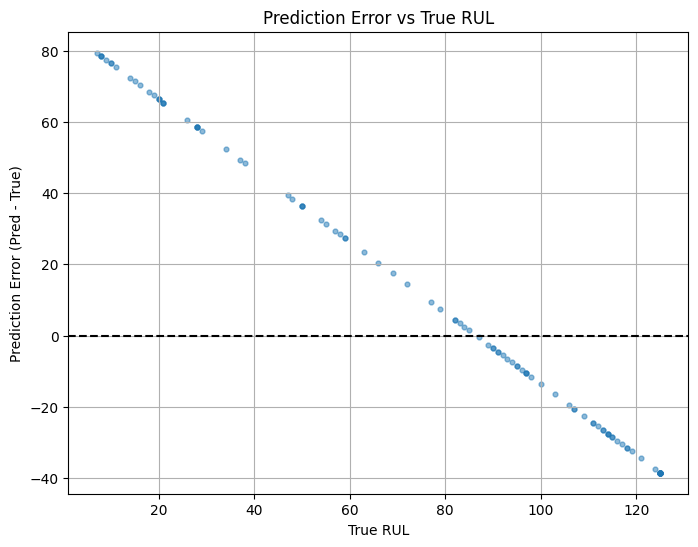

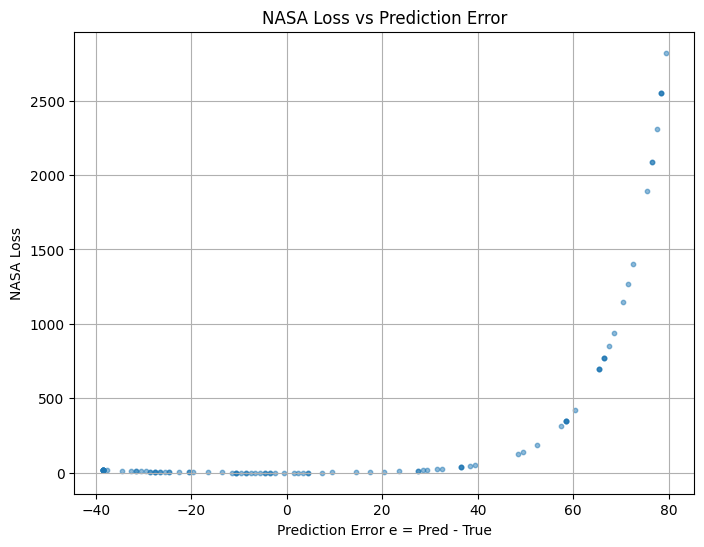

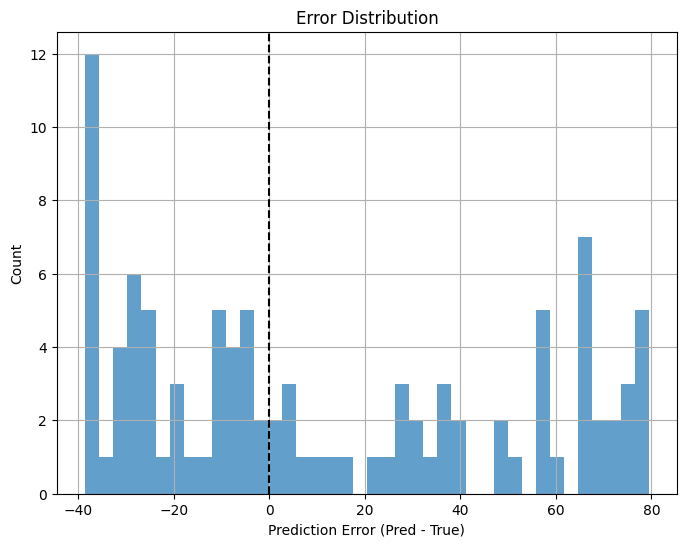

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Extract results_df from eol_metrics if available
if 'eol_metrics' in globals() and 'results_df' in eol_metrics:
    results_df = eol_metrics["results_df"]
else:
    raise ValueError("eol_metrics not found. Please run the evaluation first (Cell 2).")

true_rul = results_df["true_rul"].values
pred_rul = results_df["pred_rul"].values
errors = pred_rul - true_rul

plt.figure(figsize=(8,6))
plt.scatter(true_rul, errors, alpha=0.5, s=12)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("True RUL")
plt.ylabel("Prediction Error (Pred - True)")
plt.title("Prediction Error vs True RUL")
plt.grid(True)
plt.show()

def nasa_loss(e):
    if e >= 0:
        return np.exp(e / 10.0) - 1.0
    else:
        return np.exp(-e / 13.0) - 1.0

errors = pred_rul - true_rul
nasa_values = np.array([nasa_loss(e) for e in errors])

plt.figure(figsize=(8,6))
plt.scatter(errors, nasa_values, alpha=0.5, s=10)
plt.xlabel("Prediction Error e = Pred - True")
plt.ylabel("NASA Loss")
plt.title("NASA Loss vs Prediction Error")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.hist(errors, bins=40, alpha=0.7)
plt.axvline(0, color='k', linestyle='--')
plt.xlabel("Prediction Error (Pred - True)")
plt.ylabel("Count")
plt.title("Error Distribution")
plt.grid(True)
plt.show()



In [29]:
import numpy as np
import pandas as pd

# Falls noch nicht geschehen:
# results_df = pd.DataFrame({"true_rul": true_rul, "pred_rul": pred_rul})

true_rul = results_df["true_rul"].values.astype(float)
pred_rul = results_df["pred_rul"].values.astype(float)

# 1. Lineare Regression: true ≈ alpha * pred + beta
alpha, beta = np.polyfit(pred_rul, true_rul, deg=1)

print(f"Kalibrierung: true ≈ {alpha:.4f} * pred + {beta:.4f}")


Kalibrierung: true ≈ 0.4365 * pred + 37.2250


C:\Users\rober\AppData\Local\Temp\ipykernel_13180\4055109382.py:11: RankWarning: Polyfit may be poorly conditioned
  alpha, beta = np.polyfit(pred_rul, true_rul, deg=1)


In [30]:
MAX_RUL = 125  # falls du in FD001 mit 125 clampst

pred_rul_calib = alpha * pred_rul + beta

# Optional: auf physikalisch sinnvolle Grenzen begrenzen
pred_rul_calib_clipped = np.clip(pred_rul_calib, 0, MAX_RUL)

results_df["pred_rul_calib"] = pred_rul_calib
results_df["pred_rul_calib_clipped"] = pred_rul_calib_clipped


In [31]:
def compute_basic_metrics(y_true, y_pred):
    errors = y_pred - y_true
    mse = np.mean(errors**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(errors))
    bias = np.mean(errors)
    return mse, rmse, mae, bias, errors

def nasa_loss_from_errors(errors):
    # NASA/PHM08 Score pro Sample
    loss = np.where(
        errors >= 0,
        np.exp(errors / 10.0) - 1.0,
        np.exp(-errors / 13.0) - 1.0,
    )
    return loss


In [32]:
# A) Original (zur Kontrolle)
mse_orig, rmse_orig, mae_orig, bias_orig, errors_orig = compute_basic_metrics(true_rul, pred_rul)
nasa_orig = nasa_loss_from_errors(errors_orig)
print("== Original ==")
print(f"MSE:  {mse_orig:.3f}")
print(f"RMSE: {rmse_orig:.3f}")
print(f"MAE:  {mae_orig:.3f}")
print(f"Bias: {bias_orig:.3f}")
print(f"NASA mean: {nasa_orig.mean():.3f}")

# B) Kalibriert (ungeclippt)
mse_cal, rmse_cal, mae_cal, bias_cal, errors_cal = compute_basic_metrics(true_rul, pred_rul_calib)
nasa_cal = nasa_loss_from_errors(errors_cal)
print("\n== Kalibriert (ungeclippt) ==")
print(f"MSE:  {mse_cal:.3f}")
print(f"RMSE: {rmse_cal:.3f}")
print(f"MAE:  {mae_cal:.3f}")
print(f"Bias: {bias_cal:.3f}")
print(f"NASA mean: {nasa_cal.mean():.3f}")

# C) Kalibriert + geclippt
mse_cal_c, rmse_cal_c, mae_cal_c, bias_cal_c, errors_cal_c = compute_basic_metrics(true_rul, pred_rul_calib_clipped)
nasa_cal_c = nasa_loss_from_errors(errors_cal_c)
print("\n== Kalibriert + geclippt [0, MAX_RUL] ==")
print(f"MSE:  {mse_cal_c:.3f}")
print(f"RMSE: {rmse_cal_c:.3f}")
print(f"MAE:  {mae_cal_c:.3f}")
print(f"Bias: {bias_cal_c:.3f}")
print(f"NASA mean: {nasa_cal_c.mean():.3f}")


== Original ==
MSE:  1723.206
RMSE: 41.512
MAE:  34.830
Bias: 10.832
NASA mean: 286.731

== Kalibriert (ungeclippt) ==
MSE:  1605.867
RMSE: 40.073
MAE:  35.847
Bias: -0.000
NASA mean: 105.794

== Kalibriert + geclippt [0, MAX_RUL] ==
MSE:  1605.867
RMSE: 40.073
MAE:  35.847
Bias: -0.000
NASA mean: 105.794
